In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
fullDF = pd.read_csv('/home/welling/git/synecoace/data/nsch_2016_topical.csv')
print fullDF.columns

Index([u'FIPSST', u'HHID', u'FORMTYPE', u'TOTKIDS_R', u'HHLANGUAGE',
       u'SC_AGE_YEARS', u'SC_SEX', u'K2Q35A_1_YEARS', u'MOMAGE',
       u'K6Q41R_STILL',
       ...
       u'BIRTHWT', u'CBSAFP_YN', u'FWC', u'CURRINS', u'INSTYPE', u'HOUSE_GEN',
       u'HHSIZE_I', u'HHSIZE_IF', u'FPL_IF', u'INSGAP'],
      dtype='object', length=422)


In [3]:
# We need to restrict FIPS code to 45
print [col for col in fullDF.columns if 'FIP' in col]
print fullDF['FIPSST']

['FIPSST']
0        18
1        17
2        50
3        51
4        53
5         9
6        47
7        46
8        30
9        34
10       46
11       31
12       42
13       19
14       36
15       27
16       12
17       54
18       26
19        8
20       48
21       55
22       26
23       19
24       32
25       38
26       23
27       33
28       22
29       33
         ..
50182    15
50183     6
50184    16
50185    21
50186    12
50187    26
50188    19
50189    26
50190    11
50191    33
50192    30
50193    26
50194    27
50195     4
50196    56
50197    50
50198    24
50199    42
50200    26
50201    55
50202    56
50203    38
50204    11
50205    28
50206    40
50207     2
50208    15
50209    50
50210    31
50211    37
Name: FIPSST, Length: 50212, dtype: int64


## The Model ##

Consider two sequential ages, say 6 and 7 years.  Given an child at one age, the goal is to produce a *guide function* which can be used to select a collection of children at the other age which as a group describe the most likely match to the original child.  Specifically, given a sample of individuals at one age, the guide function should generate samples at the other age having the highest possible *mutual information* with the first group.

The guided samples will be selected by applying *Metropolis sampling* using the guide function.  This requires only that the guide function be positive definite and integrable.  In essense the guide function is proportional to the likelihood that a sampled child at one age matches a specific child at the other age.

We will develop an appropriate guide function by defining a function of an appropriate form in terms of a set of weights.  Samples will be drawn based on the given weights, the mutual information will be calculated, and the weights will be updated so as to increase the mutual information.  This process will be repeated until the mutual information is maximized.  The set of weights which produces the maximum mutual information is the optimal choice of weights given the initial choice of form for the guide function.

## Factors we are using ##
* ACE7: experienced violence
* ACE8: drugs and alcohol
* SC_AGE_YEARS: selected child age
* K4Q32X01: vision tested by eye doctor (2.0 -> False)
* K7Q30: sports teams
* K7Q31: clubs or organizations
* FPL: percent of federal poverty level?
* AGEPOS4: birth order
* FWC: sample weight
* YEAR: survey year

In [4]:
subDF=fullDF[['ACE7', 'ACE8', 'FWC', 'YEAR', 'FPL', 'SC_AGE_YEARS','K4Q32X01', 'K7Q30', 'K7Q31', 'AGEPOS4']]
subDF = subDF.dropna()
print len(subDF)
#print subDF

28084


In [5]:
age6DF = subDF[subDF.SC_AGE_YEARS==6]
print len(age6DF)
age7DF = subDF[subDF.SC_AGE_YEARS==7]
print len(age7DF)

1768
1872


Select samples from the table in a weighted fashion

In [6]:
def mkSamps(df, nSamp):
    fracWt = df['FWC']/df['FWC'].sum()
    choices = np.random.choice(len(df), nSamp, p=fracWt)
    return df.iloc[choices].drop(columns=['FWC'])
nSamp = 10
print mkSamps(age6DF, nSamp)


       ACE7  ACE8    YEAR    FPL  SC_AGE_YEARS  K4Q32X01  K7Q30  K7Q31  \
7561    2.0   2.0  2016.0  400.0           6.0       2.0    2.0    2.0   
17930   2.0   2.0  2016.0  250.0           6.0       2.0    1.0    1.0   
33682   2.0   2.0  2016.0   90.0           6.0       2.0    2.0    2.0   
20989   2.0   2.0  2016.0  400.0           6.0       2.0    1.0    2.0   
40040   2.0   2.0  2016.0  231.0           6.0       1.0    2.0    2.0   
16585   2.0   2.0  2016.0  400.0           6.0       1.0    1.0    1.0   
49868   2.0   2.0  2016.0  374.0           6.0       2.0    1.0    1.0   
25014   2.0   2.0  2016.0   50.0           6.0       2.0    2.0    2.0   
14070   2.0   2.0  2016.0  164.0           6.0       2.0    2.0    2.0   
23869   2.0   2.0  2016.0  400.0           6.0       1.0    1.0    1.0   

       AGEPOS4  
7561       1.0  
17930      2.0  
33682      4.0  
20989      3.0  
40040      4.0  
16585      1.0  
49868      3.0  
25014      3.0  
14070      3.0  
23869      3.0 

In [226]:
COLUMN_DICT = {key : idx for idx, key in enumerate(mkSamps(subDF, 1).columns)}
print COLUMN_DICT
INV_COLUMN_DICT = {val:key for key, val in COLUMN_DICT.items()}
print INV_COLUMN_DICT

{'K4Q32X01': 5, 'FPL': 3, 'K7Q31': 7, 'K7Q30': 6, 'ACE8': 1, 'YEAR': 2, 'AGEPOS4': 8, 'ACE7': 0, 'SC_AGE_YEARS': 4}
{0: 'ACE7', 1: 'ACE8', 2: 'YEAR', 3: 'FPL', 4: 'SC_AGE_YEARS', 5: 'K4Q32X01', 6: 'K7Q30', 7: 'K7Q31', 8: 'AGEPOS4'}


FPL needs to be binned to form a histogram to get the quantization we need for this.  Bins of 50 seems OK.

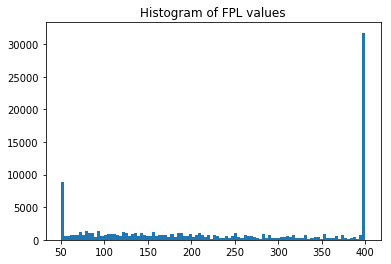

In [8]:
fplSamps = mkSamps(subDF, 100000)['FPL']
plt.hist(fplSamps, bins=100)
plt.title('Histogram of FPL values')
plt.show()

We need to enumerate the possible states for our variables.  Assume fixed age and ignore the ACE components for the moment.  

In [62]:
def whichBin(sampV):
    """
    Input is an ndarray of sample values
    Maybe check out Pandas 'cut'
    """
    fplBinWidth = 50
    fplMin = 50
    bin = np.abs((sampV[:, COLUMN_DICT['FPL']] - fplMin) // 50).astype('int')
    assert (bin >= 0).all() and (bin < 8).all(), 'FPL out of range?'
    nBins = 8
    # Each of the following is either 1.0 or 2.0
    bin = 2 * bin + (sampV[:, COLUMN_DICT['K4Q32X01']] == 1.0)
    nBins *= 2
    bin = 2 * bin + (sampV[:, COLUMN_DICT['K7Q30']] == 1.0)
    nBins *= 2
    bin = 2 * bin + (sampV[:, COLUMN_DICT['K7Q31']] == 1.0)
    nBins *= 2
    return bin, nBins

def scatter(idx, vals, target):
    """target[idx] += vals, but allowing for repeats in idx"""
    np.add.at(target, idx.ravel(), vals.ravel())


In [42]:
def toHisto(sampV):
    """Generate a histogram of sample bins"""
    binV, nBins = whichBin(sampV)
    targ = np.zeros([nBins], dtype=np.int32)
    vals = np.ones([len(sampV)], dtype=np.int32)
    scatter(binV, vals, targ)
    return targ

In [43]:
def toProbV(sampV):
    sampH = toHisto(sampV)
    probV = sampH.astype(np.float64)
    probV /= np.sum(probV)
    return probV

In [256]:
sampV = mkSamps(subDF, 1000)
print sampV.columns
print COLUMN_DICT['FPL']
sampH = toHisto(sampV.values)
print sampH
probV = toProbV(sampV.values)
print probV

Index([u'ACE7', u'ACE8', u'YEAR', u'FPL', u'SC_AGE_YEARS', u'K4Q32X01',
       u'K7Q30', u'K7Q31', u'AGEPOS4'],
      dtype='object')
3
[37  8 12 19 54 13 19 28 19  7 12 10 40  8  6 19 14  5 14  7 20  9 15 25
  5  6  6  9 13  9  5 17  8  5 11 17 11  8  6 13  2  0  4 11  7  5  8 15
  2  0  3 11  4  6  3 13 18 16 35 69 33 34 33 99]
[0.037 0.008 0.012 0.019 0.054 0.013 0.019 0.028 0.019 0.007 0.012 0.01
 0.04  0.008 0.006 0.019 0.014 0.005 0.014 0.007 0.02  0.009 0.015 0.025
 0.005 0.006 0.006 0.009 0.013 0.009 0.005 0.017 0.008 0.005 0.011 0.017
 0.011 0.008 0.006 0.013 0.002 0.    0.004 0.011 0.007 0.005 0.008 0.015
 0.002 0.    0.003 0.011 0.004 0.006 0.003 0.013 0.018 0.016 0.035 0.069
 0.033 0.034 0.033 0.099]


Given the probV we can calculate mutual information:
$$
I(X;Y) = \sum_{y \in Y} \sum_{x \in X} p(x, y) log \left (\frac{p(x,y)}{p(x)p(y)} \right )
$$

In [257]:
def mutualInfo(sampVX, sampVY):
    assert len(sampVX) == len(sampVY), 'Sample vector lengths do not match'
    binVX, nBinsX = whichBin(sampVX)
    binVY, nBinsY = whichBin(sampVY)
    assert nBinsX == nBinsY, 'Unexpectedly got different bin counts?'
    cA = np.zeros([nBinsX, nBinsX], dtype=np.int32)
    idxV = np.ravel_multi_index(np.array([binVX, binVY]), (nBinsX, nBinsX))
    np.add.at(cA.ravel(), idxV, np.ones(len(idxV), dtype=np.int32).ravel())
    pA = cA.astype(np.float32)
    pA /= sum(pA.ravel())
    xPV = toProbV(sampVX)
    yPV = toProbV(sampVY)
    xyPA = np.einsum('i,j->ij', xPV, yPV)  # einsum is my new favorite function
    oldErr = np.seterr(invalid='ignore', divide='ignore')
    prodA = pA * np.nan_to_num(np.log(pA / xyPA))  # element-wise calculation
    np.seterr(**oldErr)
    return np.sum(prodA.ravel())

sampX = mkSamps(subDF, 3000)
sampY = mkSamps(subDF, 3000)
print mutualInfo(sampX.values, sampY.values)
print mutualInfo(sampX.values, sampX.values)
print mutualInfo(sampY.values, sampY.values)

0.5597757866221897
3.787216109785666
3.7909881907758445


In [71]:
########
# This implementation (from stackoverflow) produces the same MI values as the one above
# stackoverflow.com/questions/20491028/optimal-way-to-compute-pairwise-mutual-information-using-numpy
########
#from scipy.stats import chi2_contingency
#
#def calc_MI(x, y, bins):
#    c_xy = np.histogram2d(x, y, bins)[0]
#    g, p, dof, expected = chi2_contingency(c_xy, lambda_="log-likelihood")
#    mi = 0.5 * g / c_xy.sum()
#    return mi
#
#def mutualInfo(sampVX, sampVY):
#    assert len(sampVX) == len(sampVY), 'Sample vector lengths do not match'
#    binVX, nBinsX = whichBin(sampVX)
#    binVY, nBinsY = whichBin(sampVY)
#    assert nBinsX == nBinsY, 'Unexpectedly got different bin counts?'
#    return calc_MI(binVX, binVY, nBinsX)
#
#print mutualInfo(sampX.values, sampY.values)
#print mutualInfo(sampX.values, sampX.values)
#print mutualInfo(sampY.values, sampY.values)

Define a scalar function on a pair of samples and a weight vector

In [269]:
wtSer = pd.Series({'YEAR': 1.0,
                   'FPL':1.0e-4,  # because it's percent
                   'SC_AGE_YEARS': 1.0, 
                   'K4Q32X01': 1.0,
                   'K7Q30':1.0,
                   'K7Q31': 1.0,
                   'AGEPOS4': 1.0}, index=subDF.columns)
wtSer = wtSer.drop(labels=['ACE7', 'ACE8', 'FWC'])  # get the right index order but no extra entries
print wtSer
print wtSer.values
print wtSer.index

YEAR            1.0000
FPL             0.0001
SC_AGE_YEARS    1.0000
K4Q32X01        1.0000
K7Q30           1.0000
K7Q31           1.0000
AGEPOS4         1.0000
dtype: float64
[1.e+00 1.e-04 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00]
Index([u'YEAR', u'FPL', u'SC_AGE_YEARS', u'K4Q32X01', u'K7Q30', u'K7Q31',
       u'AGEPOS4'],
      dtype='object')


In [270]:
def funV(samps1V, samps2V, wtSerV):
    """
    Returns a numpy vector the columns of which correspond to the input samples
    """
    wtA = wtSerV
    print wtA.shape
    print samps1V.shape
    offset = samps1V.shape[1] - wtSerV.shape[0]
    print offset
    samp1A = samps1V[:, offset:]
    samp2A = samps2V[:, offset:]
    delta = samp1A - samp2A
    print 'delta', delta
    delta *= delta
    print 'delta^2', delta
    return np.exp(-np.asmatrix(wtA) * np.asmatrix(delta).transpose())
    

In [271]:
def lnLik(samps1V, samps2V, wtSerV):
    """
    funV has the right shape to fill the role of likelihood in the Metropolis algorithm.  We'll
    take the log, and use it as a log likelihood.
    """
    wtA = wtSerV
    #offset = samps1V.shape[1] - wtSer.shape[0]
    offset = samps1V.shape[1] - wtSerV.shape[0]
    samp1A = samps1V[:, offset:]
    samp2A = samps2V[:, offset:]
    delta = samp1A - samp2A
    delta *= delta
    return np.asarray((-np.asmatrix(wtA) * np.asmatrix(delta).transpose())).reshape((-1, 1))
    

In [272]:
print wtSer
print funV(mkSamps(age7DF, 3).values, mkSamps(subDF, 3).values, wtSer)
llk = lnLik(mkSamps(subDF, 3).values, mkSamps(subDF, 3).values, wtSer)
print llk


YEAR            1.0000
FPL             0.0001
SC_AGE_YEARS    1.0000
K4Q32X01        1.0000
K7Q30           1.0000
K7Q31           1.0000
AGEPOS4         1.0000
dtype: float64
(7,)
(3, 9)
2
delta [[   0.   47.   -1.    0.    0.    1.    0.]
 [   0. -350.   -5.   -1.    1.    1.   -1.]
 [   0.    0.   -8.    0.    0.    1.    3.]]
delta^2 [[0.000e+00 2.209e+03 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 1.225e+05 2.500e+01 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [0.000e+00 0.000e+00 6.400e+01 0.000e+00 0.000e+00 1.000e+00 9.000e+00]]
[[1.08511405e-01 1.21717387e-18 7.28129018e-33]]
[[-23.1684]
 [-24.6176]
 [-28.    ]]


In [132]:
# Now we need a mutator
def mutate(sampV, df, stepSzV):
    """
    Return a 'mutated' version of sampV, based on the given step sizes.  Unfortunately our samples
    are discrete and come from a table, so I'm not sure how to do this unless we first generate
    a proximity network of some sort, so for the moment let's just generate a new set of samples-
    this corresponds to an infinitely wide mutator.
    """
    return mkSamps(df, len(sampV)).values

In [133]:
# And now we can write the Metropolis code.
# Thanks to https://python4mpia.github.io/fitting_data/Metropolis-Hastings.html
# initial guess for alpha as array.

nSamp = 10000
testSamps = mkSamps(age6DF, nSamp)
guess = mkSamps(age7DF, nSamp)
# Prepare storing MCMC chain as array of arrays.
A = [guess.values]
# define stepsize of MCMC.
stepsizes = np.empty([nSamp])
stepsizes.fill(0.005)
nIter = 10000

0: 0.18208604133865033
100: 0.1840596909849798
200: 0.18104696273428494
300: 0.18114687197595183
400: 0.18536032040606112
500: 0.18054535958137194
600: 0.185272207808134
700: 0.18492641707620144
800: 0.1805296606509849
900: 0.18717826742926938
1000: 0.18724076373386622
1100: 0.19496391204433686
1200: 0.1780934129048024
1300: 0.18234850559699392
1400: 0.18399338600416576
1500: 0.18279417608368315
1600: 0.18645058460392983
1700: 0.18754912956720066
1800: 0.18787277293358834
1900: 0.18484750175609968
2000: 0.17704120898402637
2100: 0.18658550995290407
2200: 0.18840403469171485
2300: 0.1847545718441525
2400: 0.1807372182128401
2500: 0.18634320348677122
2600: 0.18335376800763048
2700: 0.18673454739216294
2800: 0.19313326136643005
2900: 0.18845072158027998
3000: 0.18586623220326018
3100: 0.1868077924181391
3200: 0.1828855458066596
3300: 0.18562409228157062
3400: 0.1817771182832252
3500: 0.18012033096359162
3600: 0.18540536371361582
3700: 0.1825228907226193
3800: 0.18179923662915237
3900: 0.1

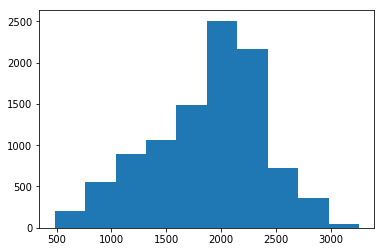

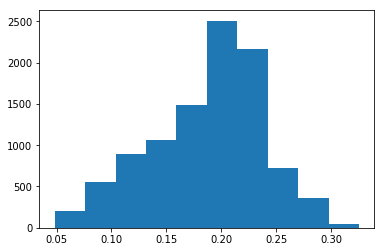

In [134]:
# Metropolis-Hastings with nIter iterations.
accepted  = np.zeros([nSamp, 1], dtype=np.int)
onesV = np.ones([nSamp], dtype=np.int).reshape((-1, 1))
zerosV = np.zeros([nSamp], dtype=np.int).reshape((-1, 1))
for n in range(nIter):
    oldAlpha  = A[-1]  # old parameter value as array
    oldLnLik = lnLik(testSamps.values, oldAlpha, wtSer)
    newAlpha = mutate(oldAlpha, age7DF, stepsizes)
    newLnLik = lnLik(testSamps.values, newAlpha, wtSer)
    if (n % 100 == 0):
        print '%s: %s' % (n, mutualInfo(testSamps.values, newAlpha))
    choices = np.logical_or(newLnLik > oldLnLik,
                            np.random.random(newLnLik.shape) < np.exp(newLnLik - oldLnLik))
    rslt = np.choose(choices, [oldAlpha, newAlpha])
    A.append(rslt)
    accepted += np.choose(choices, [zerosV, onesV])

plt.hist(accepted)
acceptanceRate = accepted/float(nIter)
plt.show()
plt.hist(acceptanceRate)
plt.show()

In [135]:
nKeep = accepted.min()/10  # 10 mutations between samples to avoid correlation
keepStep = nIter//nKeep
burnIn = 10 * keepStep
print nKeep, keepStep, burnIn
assert burnIn < nIter, 'Not enough iterations for burn-in'
clean = []
for idx, sV in enumerate(A[burnIn:]):
    if idx % keepStep == 0:
        clean.append(sV)


48 208 2080


In [136]:
#print expandedTestV
print mutualInfo(expandedTestV, cleanV)
print mutualInfo(expandedTestV, mkSamps(age7DF, cleanV.shape[0]).values)
print mutualInfo(expandedTestV, expandedTestV)
print mutualInfo(cleanV, cleanV)

0.946836977993063
0.004740312835461998
3.634444265408133
3.641075825433436


In [332]:
def genRawMetropolisSamples(nSamp, nIter, guess, lnLikFun, lnLikParams, mutator, mutatorParams,
                            verbose=False):
    """
    Parameters:
        nSamp: number of samples in the vector of current samples
        nIter: the number of iterations- this many vectors of raw samples will be drawn
        guess: the initial vector of samples to be mutated
        lnLikFun: a function returning the log likelihood, used in the Metropolis ratio
        
            lnLik = lnLikFun(samples, **lnLikParams)
            
        lnLikParms: passed to lnLikFun as above
        mutator: function implementing the Metropolis mutation, of the form
        
            newSamps = mutator(oldSamps, **mutatorParams)

        mutatorParams: passed to mutator as above
    Returns:
        A: list of vectors of samples after Metropolis acceptance
        acceptanceRate: integer vector of acceptance rate for each element of the vectors in A
    """
    # Metropolis-Hastings with nIter iterations.
    accepted  = np.zeros([nSamp, 1], dtype=np.int)
    onesV = np.ones([nSamp], dtype=np.int).reshape((-1, 1))
    zerosV = np.zeros([nSamp], dtype=np.int).reshape((-1, 1))
    A = [guess.values] # List of vectors of samples
    for n in range(nIter):
        oldAlpha  = A[-1]  # old parameter value as array
        oldLnLik = lnLikFun(oldAlpha, **lnLikParams)
        newAlpha = mutator(oldAlpha, **mutatorParams)
        newLnLik = lnLikFun(newAlpha, **lnLikParams)
        if verbose and (n % 100 == 0):
            print '%s: %s' % (n, np.sum(newLnLik))
        llDelta = newLnLik - oldLnLik
        llDelta = np.minimum(llDelta, 1.0)
        #choices = np.logical_or(newLnLik > oldLnLik,
        #                        np.random.random(newLnLik.shape) < np.exp(newLnLik - oldLnLik))
        choices = np.logical_or(newLnLik > oldLnLik,
                                np.random.random(newLnLik.shape) < np.exp(llDelta))
        rslt = np.choose(choices, [oldAlpha, newAlpha])
        A.append(rslt)
        accepted += np.choose(choices, [zerosV, onesV])
    acceptanceRate = accepted/float(nIter)
    return A, acceptanceRate

In [333]:
def genMetropolisSamples(nSamp, nIter, guess, lnLikFun, lnLikParams, mutator, mutatorParams,
                        mutationsPerSamp=10, burninMutations=10, verbose=False):
    """
    Generates independent samples by metropolis sampling with genRawMetropolisSamples and
    discarding enough samples to assure independence.
    Parameters:
        nSamp: number of samples in the vector of current samples
        nIter: the number of iterations- this many vectors of raw samples will be drawn
        guess: the initial vector of samples to be mutated
        lnLikFun: a function returning the log likelihood, used in the Metropolis ratio
        
            lnLik = lnLikFun(samples, **lnLikParams)
            
        lnLikParms: passed to lnLikFun as above
        mutator: function implementing the Metropolis mutation, of the form
        
            newSamps = mutator(oldSamps, mutatorParams)

        mutatorParams: passed to mutator as above
        mutatationsPerSamp: minimum number of accepted mutations between retained samples (on average)
        burninMutations: number of independent samples to discard during burn-in sampling
    Returns:
        cleanSamps: a list of vectors of independent samples
    """
    A, acceptanceRate = genRawMetropolisSamples(nSamp, nIter, guess, lnLikFun, lnLikParams,
                                                mutator, mutatorParams, verbose=verbose)
    nKeep = accepted.min()/10  # 10 mutations between samples to avoid correlation
    keepStep = nIter//nKeep
    burnIn = burninMutations * keepStep
    #print nKeep, keepStep, burnIn
    assert burnIn < nIter, 'Not enough iterations for burn-in'
    clean = []
    for idx, sV in enumerate(A[burnIn:]):
        if idx % keepStep == 0:
            clean.append(sV)
    return clean

In [334]:
# This function takes lnLik from the environment!
def sampleAndCalcMI(wtSer, nSamp, nIter, sampler, testSampParams, genSampParams,
                   mutator, mutatorParams, drawGraph=False, verbose=False):
    testSamps = sampler(nSamp, **testSampParams)
    guess = sampler(nSamp, **genSampParams)
    lnLikParams = {'samps2V': testSamps.values, 'wtSerV': wtSer}
    cleanSamps = genMetropolisSamples(nSamp, nIter, guess, lnLik, lnLikParams,
                                      mutate, mutatorParams, verbose=verbose)
    cleanV = np.concatenate(cleanSamps)
    expandedTestV = np.concatenate([testSamps.values] * len(cleanSamps))
    
    if drawGraph:
        testBins, nBins = whichBin(expandedTestV)
        rsltBins = whichBin(cleanV)[0]
        hM, xEdges, yEdges = np.histogram2d(testBins, rsltBins, bins=64)
        plt.imshow(np.log(hM + 1))
        plt.show()

    return mutualInfo(cleanV, expandedTestV)

0: -8437.978200000001
100: -8186.197800000001
200: -8366.2091
300: -8610.1657
400: -8174.6893
500: -8478.1623
600: -8195.929
700: -8134.6949
800: -8134.3451000000005
900: -8248.9924


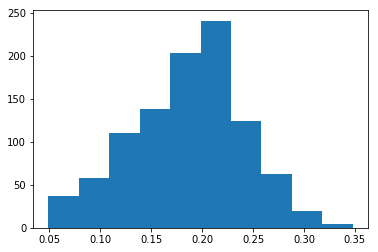

In [335]:
nSamp = 1000
nIter = 1000
guess = mkSamps(age7DF, nSamp)
testSamps = mkSamps(age6DF, nSamp)
stepsizes = np.empty([nSamp])
stepsizes.fill(0.005)
mutatorParams = {'stepSzV': stepsizes, 'df': age7DF}
lnLikParams = {'samps2V': testSamps.values, 'wtSerV': wtSer}
A, acceptanceRate = genRawMetropolisSamples(nSamp, nIter, guess,  lnLik, lnLikParams,
                                            mutate, mutatorParams, verbose=True)
plt.hist(acceptanceRate)
plt.show()

In [336]:
nSamp = 1000
nIter = 1000
testSamps = mkSamps(age6DF, nSamp)
guess = mkSamps(age7DF, nSamp)
stepsizes = np.empty([nSamp])
stepsizes.fill(0.005)
lnLikParams = {'samps2V': testSamps.values, 'wtSerV': wtSer}
mutatorParams = {'stepSzV': stepsizes, 'df': age7DF}

cleanSamps= genMetropolisSamples(nSamp, nIter, guess, lnLik, lnLikParams,
                                 mutate, mutatorParams, verbose=False)
print len(cleanSamps)

41


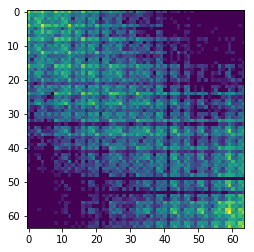

0.9471299531276878


In [337]:
nSamp = 10000
nIter = 10000
stepsizes = np.empty([nSamp])
stepsizes.fill(0.005)
def sampler(nSamp, df):
    return mkSamps(df, nSamp)
testSampParams = {'df': age6DF}
genSampParams = {'df': age7DF}
mutatorParams = {'stepSzV': stepsizes, 'df': age7DF}
print sampleAndCalcMI(wtSer, nSamp, nIter, sampler, testSampParams, genSampParams,
                     mutate, mutatorParams, drawGraph=True, verbose=False)

In [338]:
from scipy.optimize import minimize
def minimizeMe(wtVec,
               nSamp, nIter, sampler, testSampParams, genSampParams,
               mutator, mutatorParams):
    wtSer = pd.Series({'YEAR': wtVec[0],
                      'FPL': wtVec[1],
                      'SC_AGE_YEARS': wtVec[2],
                      'K4Q32X01': wtVec[3],
                      'K7Q30': wtVec[4],
                      'K7Q31': wtVec[5],
                      'AGEPOS4': wtVec[6]},
                     index=subDF.columns)
    wtSer = wtSer.drop(labels=['ACE7', 'ACE8', 'FWC'])  # get the right index order but no extra entries
    mI = sampleAndCalcMI(wtSer, nSamp, nIter, sampler, testSampParams, genSampParams,
                         mutator, mutatorParams, drawGraph=False, verbose=False)
    #print mI
    return -mI

In [339]:
nSamp = 1000
nIter = 1000
stepsizes = np.empty([nSamp])
stepsizes.fill(0.005)
def sampler(nSamp, df):
    return mkSamps(df, nSamp)
testSampParams = {'df': age6DF}
genSampParams = {'df': age7DF}
mutatorParams = {'stepSzV': stepsizes, 'df': age7DF}

guess = np.array([1.0, 1.0e-4, 1.0, 1.0, 1.0, 1.0, 1.0])
rslt = minimize(minimizeMe, guess, (nSamp, nIter, sampler, testSampParams, genSampParams,
                                   mutate, mutatorParams), method='powell')
print rslt

/home/welling/myEnv/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: underflow encountered in exp


   direc: array([[  1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   1.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   1.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          1.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   1.        ,   0.        ],
       [ -1.77120877,   5.33573488,  -6.29056701,   9.95290954,
        163.62522102,   5.28558648,   2.09368055]])
     fun: -2.8650307214469173
 message: 'Optimization terminated successfully.'
    nfev: 194
     nit: 2
  status: 0
 success: True
       x: array([  0.37161158,   6.88293472,  -8.35

In [340]:
rslt_6_7 = rslt
print rslt_6_7.x

[  0.37161158   6.88293472  -8.35524929  14.83876221 211.8886461
   7.16782256   2.70074462]


In [341]:
age8DF = subDF[subDF.SC_AGE_YEARS==8]
print len(age8DF)
age9DF = subDF[subDF.SC_AGE_YEARS==9]
print len(age9DF)
age10DF = subDF[subDF.SC_AGE_YEARS==10]
print len(age10DF)
age11DF = subDF[subDF.SC_AGE_YEARS==11]
print len(age11DF)
age12DF = subDF[subDF.SC_AGE_YEARS==12]
print len(age12DF)
age13DF = subDF[subDF.SC_AGE_YEARS==13]
print len(age13DF)
age14DF = subDF[subDF.SC_AGE_YEARS==14]
print len(age14DF)
age15DF = subDF[subDF.SC_AGE_YEARS==15]
print len(age15DF)
age16DF = subDF[subDF.SC_AGE_YEARS==16]
print len(age16DF)
age17DF = subDF[subDF.SC_AGE_YEARS==17]
print len(age17DF)
age18DF = subDF[subDF.SC_AGE_YEARS==18]
print len(age18DF)


2042
2080
2117
2219
2369
2422
2548
2781
2943
2923
0


In [342]:
ageDFD = {}
for age in range(6,18):
    ageDFD[age] = subDF[subDF.SC_AGE_YEARS==age]
    print '%s: %s' % (age, len(ageDFD[age]))

6: 1768
7: 1872
8: 2042
9: 2080
10: 2117
11: 2219
12: 2369
13: 2422
14: 2548
15: 2781
16: 2943
17: 2923


In [343]:
rsltD = {}
rsltD[(6,7)] = rslt_6_7

In [346]:
def sampler(nSamp, df):
    return mkSamps(df, nSamp)
for ageLow in range(7, 17):
    ageHigh = ageLow + 1
    print 'starting %s -> %s' % (ageLow, ageHigh)
    nSamp = 1000
    nIter = 1000
    stepsizes = np.empty([nSamp])
    stepsizes.fill(0.005)
    testSampParams = {'df': ageDFD[ageLow]}
    genSampParams = {'df': ageDFD[ageHigh]}
    mutatorParams = {'stepSzV': stepsizes, 'df': ageDFD[ageHigh]}

    guess = np.array([1.0, 1.0e-4, 1.0, 1.0, 1.0, 1.0, 1.0])
    rslt = minimize(minimizeMe, guess, (nSamp, nIter, sampler, testSampParams, genSampParams,
                                       mutate, mutatorParams), method='powell')
    print rslt
    rsltD[(ageLow, ageHigh)] = rslt

starting 7 -> 8


/home/welling/myEnv/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: underflow encountered in exp


   direc: array([[  1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   1.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   1.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          1.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   1.        ,   0.        ],
       [ -0.28686117,  -0.70452725,  -0.18866725, -58.802359  ,
          3.54122515,  -3.86306382,   0.42168529]])
     fun: -3.4006120987177875
 message: 'Optimization terminated successfully.'
    nfev: 530
     nit: 5
  status: 0
 success: True
       x: array([ 8.11634528,  0.03285228,  5.15817

In [349]:
import cPickle as pickle
with open('rsltd_20190408.pkl', 'w') as f:
    pickle.dump(rsltD, f)

6 -> 7: -2.8650307214469173


/home/welling/myEnv/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: underflow encountered in exp


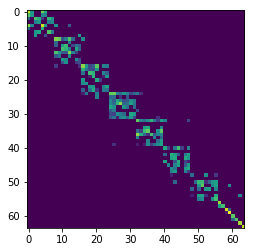

2.8464586902517155
7 -> 8: -3.4006120987177875


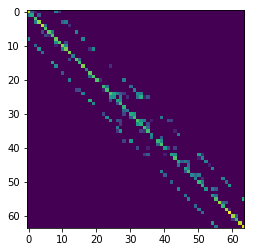

3.2923163668005433
8 -> 9: -2.8684920529908413


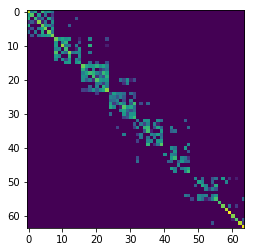

2.87663277500248
9 -> 10: -2.6839922922551294


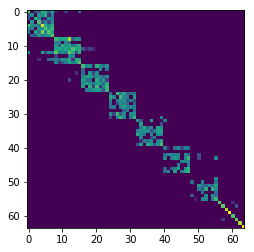

2.621694850523692
10 -> 11: -2.984130605060529


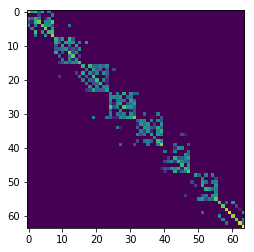

2.9460412502396114
11 -> 12: -2.8713832562515704


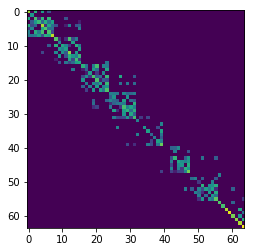

2.8523739767252936
12 -> 13: -2.8292099407868507


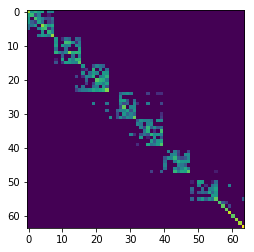

2.8138298142341
13 -> 14: -2.7617100709338


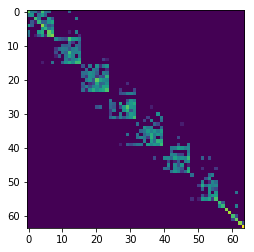

2.701866562759925
14 -> 15: -2.9608527675046146


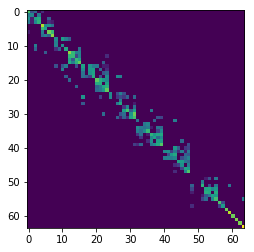

2.971612798818977
15 -> 16: -3.017166358685971


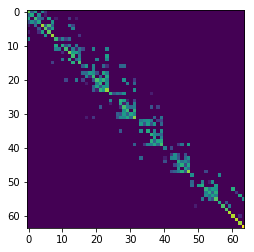

2.975671958319418
16 -> 17: -2.8803703578688467


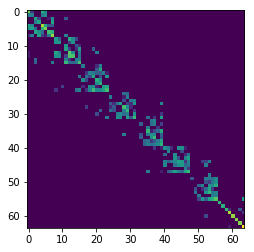

2.809253710385479


In [348]:
np.seterr(all='warn')
for ageLow in range(6, 17):
    ageHigh = ageLow + 1
    rslt = rsltD[(ageLow, ageHigh)]
    print '%s -> %s: %s' % (ageLow, ageHigh, rslt.fun)
    nSamp = 1000
    nIter = 1000
    stepsizes = np.empty([nSamp])
    stepsizes.fill(0.005)
    testSampParams = {'df': ageDFD[ageLow]}
    genSampParams = {'df': ageDFD[ageHigh]}
    mutatorParams = {'stepSzV': stepsizes, 'df': ageDFD[ageHigh]}
    finalMI = sampleAndCalcMI(rslt.x, nSamp, nIter, sampler, testSampParams, genSampParams,
                              mutator, mutatorParams, drawGraph=True, verbose=False)
    print finalMI

6 -> 7: -3.3932364265583965
[1.88854385e+00 3.23367370e-03 1.47061410e+01 2.83322669e+00
 7.94427194e+00 1.60487837e+00 6.60201561e-02]
[ 4.96713211e+00  1.59196765e-03  1.36818239e+00  5.00000003e+00
  6.44546679e+00  2.78437081e+00 -1.16632795e-02]
[ 1.88854385e+00  3.23367370e-03  1.36818239e+00  5.00000003e+00
  6.44546679e+00  2.78437081e+00 -1.16632795e-02]


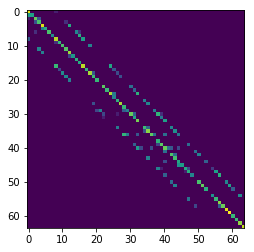

3.33583775040041


In [323]:
ageLow = 6
ageHigh = ageLow + 1
rslt = rsltD[(ageLow, ageHigh)]
print '%s -> %s: %s' % (ageLow, ageHigh, rslt.fun)
nSamp = 1000
nIter = 1000
stepsizes = np.empty([nSamp])
stepsizes.fill(0.005)
testSampParams = {'df': ageDFD[ageLow]}
genSampParams = {'df': ageDFD[ageHigh]}
mutatorParams = {'stepSzV': stepsizes, 'df': ageDFD[ageHigh]}
print rsltD[(6,7)].x
print rsltD[(7,8)].x
#testPt = np.asarray([  6.74485578,  2.32841484, 1.4463155, 310.20180186, 27.83182466,
#  13.0654487, 11.79189153 , 13.90367251])
testPt = rsltD[(7,8)].x.copy()
testPt[0:2] = rsltD[(6,7)].x[0:2]
print testPt
finalMI = sampleAndCalcMI(testPt, nSamp, nIter, sampler, testSampParams, genSampParams,
                          mutator, mutatorParams, drawGraph=True, verbose=False)
print finalMI

In [324]:
print rsltD.keys()

[(16, 17), (9, 10), (10, 11), (12, 13), (11, 12), (15, 16), (8, 9), (13, 14), (14, 15), (6, 7), (7, 8)]


In [327]:
ageLow = 6
print ('%s%s' % (' ' * 21,
                 ''.join(['{:^11s}'.format(INV_COLUMN_DICT[idx]) for idx in range(2,9)])))
while True:
    ageHigh = ageLow + 1
    if (ageLow, ageHigh) not in rsltD:
        break
    rslt = rsltD[(ageLow, ageHigh)]
    ss = ', '.join(['{: >9,.5f}'.format(val) for val in rslt.x])
    print '%2d -> %2d: %.6f:  %s' % (ageLow, ageHigh, rslt.fun, ss)
    ageLow += 1

                        YEAR        FPL    SC_AGE_YEARS K4Q32X01     K7Q30      K7Q31     AGEPOS4  
 6 ->  7: -3.393236:    1.88854,   0.00323,  14.70614,   2.83323,   7.94427,   1.60488,   0.06602
 7 ->  8: -3.489186:    4.96713,   0.00159,   1.36818,   5.00000,   6.44547,   2.78437,  -0.01166
 8 ->  9: -3.542644:    2.54010,   0.00091,   1.47691,   2.51216,   3.61803,   2.21486,   0.03090
 9 -> 10: -3.448740:    4.02343,   0.00079,   2.60045,   2.57323,   3.61803,   2.90896,   0.04528
10 -> 11: -3.443559:    7.26090,   0.00091,  -6.87068,  -2.82436,   5.55018,   2.93899,  -0.03951
11 -> 12: -3.456991:    4.06271,   0.00014,   2.15325,   4.64771,   3.02364,   3.76061,   0.01000
12 -> 13: -3.456794:    2.37934,   0.00442,   3.00000,   2.78392,   6.08061,   4.96026,  -0.02367
13 -> 14: -3.433499:    0.23607,   0.00258,   3.31646,   3.03177,   4.77132,   4.85410,  -0.10099
14 -> 15: -3.381257:    6.89512,   0.00290,   0.52650,   3.05761,   2.38197,   1.57546,   0.00653
15 -> 16: -3.39075

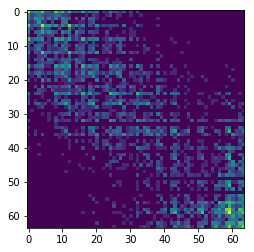

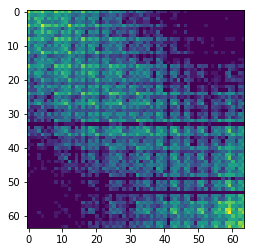

In [25]:
testBins, nBins = whichBin(testSamps.values)
rsltBins = whichBin(clean[10])[0]
hM, xEdges, yEdges = np.histogram2d(testBins, rsltBins, bins=64)
plt.imshow(np.log(hM + 1))
plt.show()

testBins, nBins = whichBin(expandedTestV)
rsltBins = whichBin(cleanV)[0]
hM, xEdges, yEdges = np.histogram2d(testBins, rsltBins, bins=64)
plt.imshow(np.log(hM + 1))
plt.show()


## Ignore the rest of this ##
These bits are just left-overs

In [25]:
wtDF = pd.DataFrame({'FPL':[1.0, 1.0], 'SC_AGE_YEARS': [1.0, 1.0], 'K4Q01': [1.0, 1.0], 'K4Q32X01': [1.0, 1.0],
       'K7Q30':[1.0, 1.0], 'K7Q31': [1.0, 1.0], 'AGEPOS4': [1.0, 1.0]}, index=['ACE7', 'ACE8'])
print wtDF

      AGEPOS4  FPL  K4Q01  K4Q32X01  K7Q30  K7Q31  SC_AGE_YEARS
ACE7      1.0  1.0    1.0       1.0    1.0    1.0           1.0
ACE8      1.0  1.0    1.0       1.0    1.0    1.0           1.0


In [26]:
def funV(samps1, samps2, wtDF):
    """
    Returns a numpy matrix the rows of which correspond to ACE7 and ACE8 and
    the columns of which correspond to the input samples
    """
    wtA = wtDF.values
    offset = samps1.values.shape[1] - wtDF.values.shape[1]
    samp1A = samps1.values[:, offset:]
    samp2A = samps2.values[:, offset:]
    delta = samp1A - samp2A
    return np.asmatrix(wtA) * np.asmatrix(delta).transpose()
    

In [27]:
print funV(mkSamps(subDF, 3), mkSamps(subDF, 3), wtDF)

[[  1. -30. -77.]
 [  1. -30. -77.]]


$\mathcal L(\{M_1,M_2,\ldots,M_N\};\alpha) = \prod_{n=1}^N p(M_n|\alpha) = \prod_{n=1}^N c\left(\frac{M_n}{M_\odot}\right)^{-\alpha}$